In [1]:
! git clone https://github.com/LM1997610/Apex_detection

Cloning into 'Apex_detection'...
remote: Enumerating objects: 182, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 182 (delta 49), reused 43 (delta 23), pack-reused 89
Receiving objects: 100% (182/182), 211.89 MiB | 15.77 MiB/s, done.
Resolving deltas: 100% (86/86), done.
Updating files: 100% (15/15), done.


In [2]:
%cd /content/Apex_detection/'Faster R-CNN'

/content/Apex_detection/Faster R-CNN


## Apex Detection with RCNN

In [3]:
! pip -q install datasets

In [4]:
import tensorflow as tf
import warnings

from datasets import load_dataset

import torch
import torchvision
from torchvision.transforms import v2 as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from apex_dataload import ApexDetection

import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Data loading

In [5]:
num_classes = 3
batch_size = 16

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore")

  dataset = load_dataset(path='Francesco/apex-videogame')

In [7]:
for key in dataset:

    dataset[key] = dataset[key].flatten()
    dataset[key] = dataset[key].filter(lambda example: tf.shape(example['objects.bbox'])[0] > 0)

train_d = dataset['train']
val_d = dataset['validation']
test_d = dataset['test']

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

def get_transform(train=False):
    transforms = []

    if train:
        transforms.extend([#T.RandomHorizontalFlip(0.5),
                           #T.RandomRotation(degrees=35),
                           #T.RandomResizedCrop(size=(640, 640)),
                           T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                           T.GaussianBlur(kernel_size=3)])

    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())

    return T.Compose(transforms)

In [9]:
train_data = ApexDetection(root = train_d, transforms = get_transform(train=True))
val_data = ApexDetection(root = val_d, transforms = get_transform(train=True))
test_data = ApexDetection(root = test_d)

data_loader_train = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
data_loader_val = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

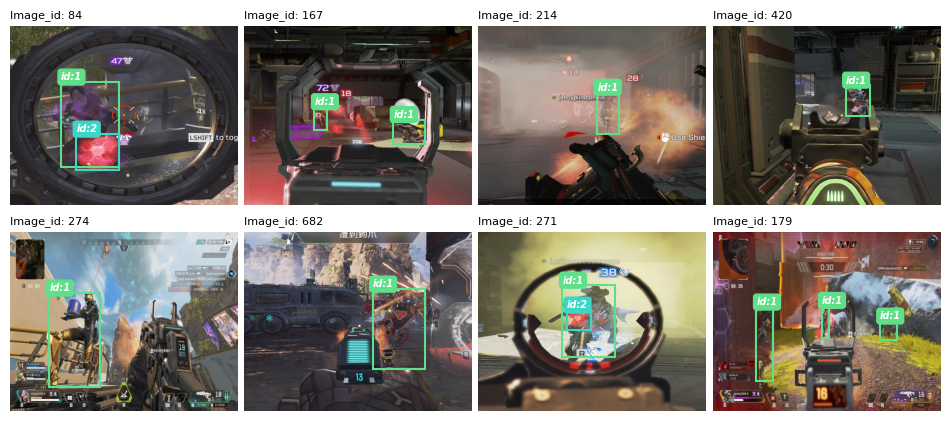

In [10]:
f, axs = plt.subplots(2, 4, sharey=True, figsize=(12, 5))
axs = axs.flatten()

imgs_index = [0, 3, 6, 8, 10, 14, 47, 572]

for i, ax in zip(imgs_index, axs):

    test_data.do_plot(i, ax=ax)

plt.subplots_adjust(wspace=0.03, hspace=0.15)
plt.show()

### Get the model

In [11]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore")

  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.roi_heads.detections_per_img = 10

model=model.to(device)

100%|██████████| 8/8 [00:03<00:00,  2.48it/s]


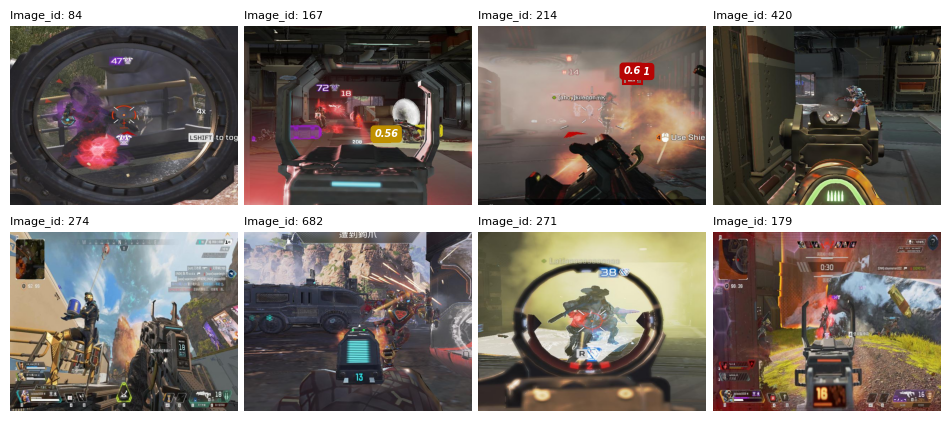

In [12]:
f, axs = plt.subplots(2, 4, sharey=True, figsize=(12, 5))
axs = axs.flatten()

imgs_index = [0, 3, 6, 8, 10, 14, 47, 572]

for i, ax in tqdm(zip(imgs_index, axs), total = len(imgs_index)):

    test_data.do_plot(i, ax=ax, model=model, treshold=0.55)

plt.subplots_adjust(wspace=0.03, hspace=0.15)
plt.show()

### Training:

In [13]:
! cp -a /content/Apex_detection/'Faster R-CNN'/modules/. /content/Apex_detection/'Faster R-CNN'

In [14]:
from engine import train_one_epoch, evaluate

In [15]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
num_epochs = 10

history_train, history_val = [], []

for epoch in range(num_epochs):

    h = train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=100)
    lr_scheduler.step()
    history_train.append(h.meters)

    v = evaluate(model, data_loader_val, device=device)
    history_val.append(v)

# model = torch.load('the_model_v1.pt')

### Inference:

In [16]:
#! gdown 1B_e2BfbgnYFUv5Tb2_li32WnSDKSoHpY

Downloading...
From (original): https://drive.google.com/uc?id=1B_e2BfbgnYFUv5Tb2_li32WnSDKSoHpY
From (redirected): https://drive.google.com/uc?id=1B_e2BfbgnYFUv5Tb2_li32WnSDKSoHpY&confirm=t&uuid=95449d80-4bf8-4239-9995-c7e4cf0323b4
To: /content/Apex_detection/Faster R-CNN/the_model_v1.pt
100% 166M/166M [00:01<00:00, 93.3MB/s]


In [17]:
model.load_state_dict(torch.load("the_model_v1.pt")) #map_location=torch.device('cpu')

<All keys matched successfully>

100%|██████████| 8/8 [00:00<00:00,  8.89it/s]


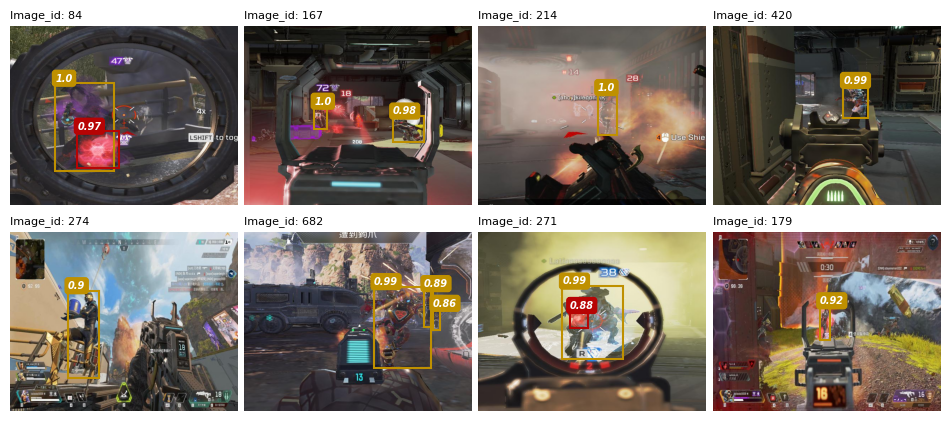

In [18]:
f, axs = plt.subplots(2, 4, sharey=True, figsize=(12, 5))
axs = axs.flatten()

imgs_index = [0, 3, 6, 8, 10, 14, 47, 572]

for i, ax in tqdm(zip(imgs_index, axs), total = len(imgs_index)):

    test_data.do_plot(i, ax=ax, model=model, treshold=0.84)

plt.subplots_adjust(wspace=0.03, hspace=0.15)
plt.show()

In [19]:
# Evaluation on test set:

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
evaluate(model, test_loader, device=device)

creating index...
index created!
Test:  [ 0/44]  eta: 0:01:01  model_time: 1.1211 (1.1211)  evaluator_time: 0.0092 (0.0092)  time: 1.4029  data: 0.2538  max mem: 7065
Test:  [43/44]  eta: 0:00:01  model_time: 1.1120 (1.0874)  evaluator_time: 0.0077 (0.0089)  time: 1.3169  data: 0.2239  max mem: 7065
Test: Total time: 0:00:59 (1.3617 s / it)
Averaged stats: model_time: 1.1120 (1.0874)  evaluator_time: 0.0077 (0.0089)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.459
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.790
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.486
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.479
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.461
 Average Recall     (AR) @[ IoU=

In [20]:
img, target = test_data.__getitem__(idx=3)

start_time = time.time()
boxes, labels, scores = test_data.__prediction__(img, model, threshold=0.97)

elapsed_time = time.time() - start_time

print("Time taken:", elapsed_time, "seconds")  # with Colab GPU

Time taken: 0.07598471641540527 seconds
